Loading data...
Computing composite seed score...
Selecting seed proteins...
Seeds: ['9606.ENSP00000364210', '9606.ENSP00000363089', '9606.ENSP00000263341', '9606.ENSP00000260010', '9606.ENSP00000398698', '9606.ENSP00000385675', '9606.ENSP00000226574', '9606.ENSP00000264832', '9606.ENSP00000346839', '9606.ENSP00000262940', '9606.ENSP00000372924', '9606.ENSP00000286364', '9606.ENSP00000377075', '9606.ENSP00000303192', '9606.ENSP00000420211', '9606.ENSP00000362680', '9606.ENSP00000275493', '9606.ENSP00000256078', '9606.ENSP00000294728', '9606.ENSP00000263025']
Building graph...
Graph: 89 nodes, 678 edges
Building matrix...
Running RWR...

TOP 20 ESSENTIAL PROTEINS:
stringdb::database identifier  composite_seed_score  rwr_score
         9606.ENSP00000256078              0.404485   0.061226
         9606.ENSP00000363089              0.524554   0.043230
         9606.ENSP00000398698              0.442922   0.043065
         9606.ENSP00000226574              0.426878   0.043022
         9606

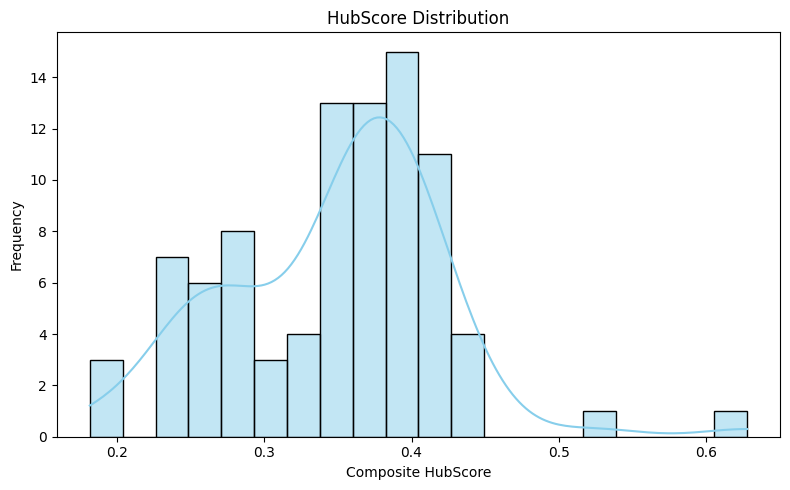

stringdb::database identifier         protein_name  rwr_score
         9606.ENSP00000256078 9606.ENSP00000256078   0.061226
         9606.ENSP00000363089 9606.ENSP00000363089   0.043230
         9606.ENSP00000398698 9606.ENSP00000398698   0.043065
         9606.ENSP00000226574 9606.ENSP00000226574   0.043022
         9606.ENSP00000385675 9606.ENSP00000385675   0.042934
         9606.ENSP00000346839 9606.ENSP00000346839   0.042584
         9606.ENSP00000263341 9606.ENSP00000263341   0.042466
         9606.ENSP00000275493 9606.ENSP00000275493   0.042264
         9606.ENSP00000264832 9606.ENSP00000264832   0.042091
         9606.ENSP00000263025 9606.ENSP00000263025   0.041899
         9606.ENSP00000260010 9606.ENSP00000260010   0.041864
         9606.ENSP00000362680 9606.ENSP00000362680   0.041830
         9606.ENSP00000294728 9606.ENSP00000294728   0.040915
         9606.ENSP00000364210 9606.ENSP00000364210   0.040874
         9606.ENSP00000303192 9606.ENSP00000303192   0.038573
        

C:\Users\preti\AppData\Local\Temp\ipykernel_10560\1687481632.py:248: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="rwr_score", y="protein_name", data=top20, palette="viridis")


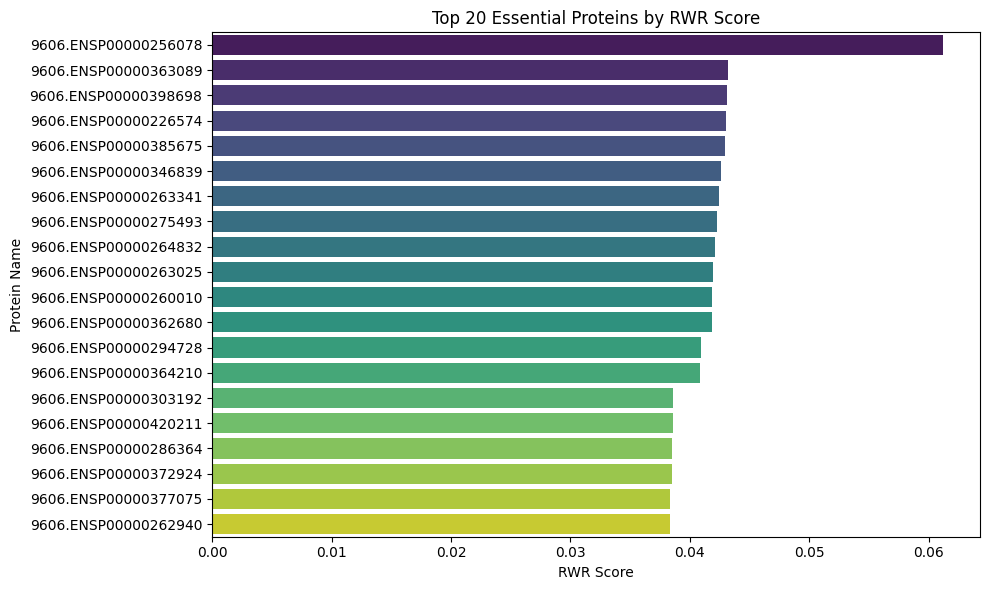

,stringdb::database identifier,composite_seed_score,rwr_score
15,9606.ENSP00000256078,0.404485,0.061226
9,9606.ENSP00000363089,0.524554,0.043230
44,9606.ENSP00000398698,0.442922,0.043065
22,9606.ENSP00000226574,0.426878,0.043022
42,9606.ENSP00000385675,0.430729,0.042934
...,...,...,...
1,9606.ENSP00000342848,0.253915,0.000093
5,9606.ENSP00000380450,0.253915,0.000092
87,9606.ENSP00000361400,0.283579,0.000043
79,9606.ENSP00000278282,0.259158,0.000042


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import requests

STRING_API_BASE = "https://version-12-0.string-db.org/api/json"

TOL = 1e-8
MAX_ITER = 500

def parse_interaction_string(s):
    if pd.isna(s): 
        return None

    s = str(s).strip()
    parts = s.split()

    if len(parts) >= 3:
        A = parts[0].strip()
        B = parts[-1].strip()
        return A, B

    return None


def read_node_table(path, id_col):
    df = pd.read_csv(path, dtype=str)

    metrics = [
        "Degree","BetweennessCentrality","ClosenessCentrality","Stress",
        "Radiality","NeighborhoodConnectivity","Eccentricity",
        "ClusteringCoefficient","TopologicalCoefficient"
    ]

    for m in metrics:
        if m in df.columns:
            df[m] = pd.to_numeric(df[m], errors="coerce")

    return df



def read_edge_table(path):
    return pd.read_csv(path, dtype=str)


# ---------------------------------------------------------
# COMPOSITE SEED SCORE
# ---------------------------------------------------------
def compute_composite(node_df):
    metrics = [
        "Degree","BetweennessCentrality","ClosenessCentrality","Stress",
        "NeighborhoodConnectivity","ClusteringCoefficient","TopologicalCoefficient"
    ]

    metrics = [m for m in metrics if m in node_df.columns]

    normed = pd.DataFrame(index=node_df.index)
    for m in metrics:
        col = node_df[m]
        if col.isna().all():
            normed[m] = 0
        else:
            minv, maxv = col.min(), col.max()
            if minv == maxv:
                normed[m] = 0
            else:
                normed[m] = (col - minv) / (maxv - minv)

    node_df["composite_seed_score"] = normed.mean(axis=1).fillna(0)
    return node_df


# ---------------------------------------------------------
#  BUILD GRAPH USING FIXED PARSER
# ---------------------------------------------------------
def build_graph(edges_df, node_ids, interaction_col="name", weight_col="stringdb::score"):

    G = nx.Graph()
    G.add_nodes_from(node_ids)

    for _, row in edges_df.iterrows():
        parsed = parse_interaction_string(row.get(interaction_col, ""))

        if parsed is None:
            continue

        a, b = parsed

        if a not in node_ids or b not in node_ids:
            continue

        # edge weight
        w = 1.0
        if weight_col in row and pd.notna(row[weight_col]):
            try: w = float(row[weight_col])
            except: pass

        G.add_edge(a, b, weight=w)

    return G


# ---------------------------------------------------------
#  TRANSITION MATRIX
# ---------------------------------------------------------
def build_transition_matrix(G, node_list):
    n = len(node_list)
    idx = {node_list[i]: i for i in range(n)}

    rows, cols, data = [], [], []

    for j, node in enumerate(node_list):
        neighs = list(G[node])
        if len(neighs) == 0:
            continue

        weights = [float(G[node][nb].get("weight", 1.0)) for nb in neighs]
        total = sum(weights)

        for nb, w in zip(neighs, weights):
            i = idx[nb]
            rows.append(i)
            cols.append(j)
            data.append(w / total)

    return sp.csr_matrix((data, (rows, cols)), shape=(n, n))


# ---------------------------------------------------------
#  RANDOM WALK WITH RESTART
# ---------------------------------------------------------
def rwr(W, seed_idx, alpha=0.75):
    n = W.shape[0]
    p0 = np.zeros(n)
    p0[seed_idx] = 1
    p0 /= p0.sum()

    p = p0.copy()
    for _ in range(MAX_ITER):
        p_new = (1 - alpha) * (W @ p) + alpha * p0
        if np.linalg.norm(p_new - p, 1) < TOL:
            break
        p = p_new

    return p

def get_protein_name(string_id, species=9606):
    """
    Maps a STRING ID to the human-readable protein name using STRING API.
    """
    params = {
        "identifiers": string_id,
        "species": species,
    }
    try:
        resp = requests.post(f"{STRING_API_BASE}/get_string_ids", data=params)
        resp.raise_for_status()
        data = resp.json()
        if data and isinstance(data, list) and "preferred_name" in data[0]:
            return data[0]["preferred_name"]
    except Exception as e:
        print(f"Error fetching name for {string_id}: {e}")
    return string_id 

def map_string_id_to_name(string_ids, taxon_id):
    """Returns a dictionary mapping STRING IDs to protein names (preferredName)."""
    params = {
        "identifiers": "\r".join(string_ids),
        "species": taxon_id,
        "limit": 1,
        "caller_identity": "my_app"
    }
    resp = requests.post(f"{STRING_API_BASE}/get_string_ids", data=params)
    data = resp.json()
    mapping = {}
    for item in data:
        string_id = item.get("stringId")
        name = item.get("preferredName") or item.get("queryItem")
        if string_id:
            mapping[string_id] = name
    return mapping


# ---------------------------------------------------------
# FULL PIPELINE
# ---------------------------------------------------------
def run_rwr_pipeline(
    node_csv,
    edge_csv,
    id_col="stringdb::database identifier",
    interaction_col="name",
    weight_col="stringdb::score",
    top_k_seeds=20,
    alpha=0.75,
    output_csv="./data/essential_proteins_rwr.csv"
):
    print("Loading data...")
    nodes = read_node_table(node_csv, id_col)
    edges = read_edge_table(edge_csv)

    print("Computing composite seed score...")
    nodes = compute_composite(nodes)

    node_ids = nodes[id_col].astype(str).tolist()
    node_set = set(node_ids)

    print("Selecting seed proteins...")
    seeds = nodes.sort_values("composite_seed_score", ascending=False).head(top_k_seeds)[id_col].tolist()

    print("Seeds:", seeds)

    print("Building graph...")
    G = build_graph(edges, node_set, interaction_col, weight_col)
    print("Graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

    if G.number_of_edges() == 0:
        print("ERROR: Still 0 edges → interaction parser still wrong.")
        return None

    print("Building matrix...")
    W = build_transition_matrix(G, node_ids)

    print("Running RWR...")
    seed_idx = [node_ids.index(s) for s in seeds]
    scores = rwr(W, seed_idx, alpha)

    out = pd.DataFrame({
        id_col: node_ids,
        "composite_seed_score": nodes["composite_seed_score"],
        "rwr_score": scores
    }).sort_values("rwr_score", ascending=False)

    out.to_csv(output_csv, index=False)


    print("\nTOP 20 ESSENTIAL PROTEINS:")
    print(out.head(20).to_string(index=False))
    print("\nSaved to:", output_csv)

    

    # -----------------------------
    # Generate Visualizations
    # -----------------------------
    print("Generating visualizations...")

    # 1. HubScore (composite_seed_score) Distribution Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(nodes["composite_seed_score"], bins=20, kde=True, color='skyblue')
    plt.title("HubScore Distribution")
    plt.xlabel("Composite HubScore")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("./data/hubscore_distribution_rwr.png", dpi=300)
    plt.show()

    # 2. Bar Plot for Top 20 Hub Proteins by RWR Score
    # after RWR calculation
    top_rwr = out.head(20) 

    string_id_name_map = map_string_id_to_name(top_rwr[id_col].tolist(), taxon_id)
    top_rwr["Protein_Name"] = top_rwr[id_col].map(string_id_name_map)

    print("\nTop 20 RWR Proteins with Names:")
    print(top_rwr[[id_col, "Protein_Name", "rwr_score"]])

    # Bar plot using names
    plt.figure(figsize=(12,6))
    sns.barplot(data=top_rwr, x="Protein_Name", y="rwr_score", palette="inferno")
    plt.xticks(rotation=45, ha='right')
    plt.title("Top 20 Essential Proteins by RWR Score")
    plt.xlabel("Protein Name")
    plt.ylabel("RWR Score")
    plt.tight_layout()
    plt.savefig("./data/essential20_proteins.png", dpi=300)
    plt.close()
    print("Bar plot saved to ./data/essential20_proteins.png")


    return out


# ---------------------------------------------------------
# MAIN CALL
# ---------------------------------------------------------

run_rwr_pipeline(
    node_csv="./data/node_table_with_centrality.csv",
    edge_csv="./data/edge_table.csv",
)
